In [1]:
import numpy as np
from scipy import ndimage
from scipy import spatial
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import fftpack
from scipy import signal
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import igraph
from skimage import data
from skimage import color
from skimage import img_as_float

import graph3d

%matplotlib inline

In [2]:
image = img_as_float(data.camera()[::2, ::2])

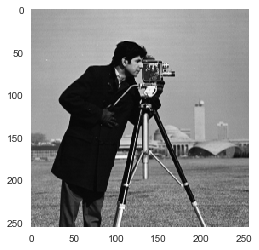

In [3]:
plt.imshow(image, cmap='gray')
plt.grid('off')

In [4]:
image = image[40:80, 100:140]
noisy_image = image + 0.05*np.random.randn(*image.shape)

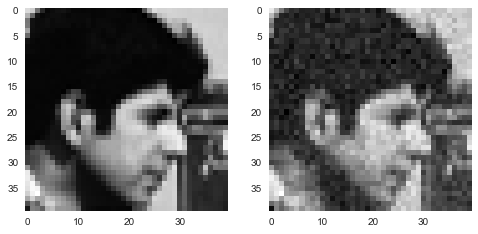

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(image, cmap='gray')
ax[1].imshow(noisy_image, cmap='gray')
ax[0].grid('off')
ax[1].grid('off')

In [6]:
kappa = 1.5
theta = 20
gamma = 10

In [7]:
yx = np.vstack(np.dstack(np.indices(noisy_image.shape)))

In [8]:
tree = spatial.cKDTree(yx)
q = tree.query_ball_point(yx, kappa)

In [9]:
I = np.concatenate([np.repeat(k, len(q[k])) for k in range(len(q))])
J = np.concatenate(q)

In [10]:
dist_ij = np.sqrt(((noisy_image.flat[I] - noisy_image.flat[J])**2))

In [11]:
W_ij = np.exp(- ((dist_ij)**2 / 2*(theta**2)) )

In [12]:
A = sparse.lil_matrix((len(yx), len(yx)))

for i, j, w in zip(I, J, W_ij):
    A[i, j] = w
    A[j, i] = w

In [13]:
A = A.tocsc()

In [14]:
A = A.todense()

In [15]:
L = csgraph.laplacian(A)

In [16]:
l, u = linalg.eigh(L)

In [17]:
h = u @ np.diag(1 / (1 + gamma*l)) @ u.T

In [18]:
graph_filtered_image = (h @ noisy_image.ravel()).reshape(noisy_image.shape)

In [19]:
traditional_filtered_image = ndimage.gaussian_filter(noisy_image, 0.8)

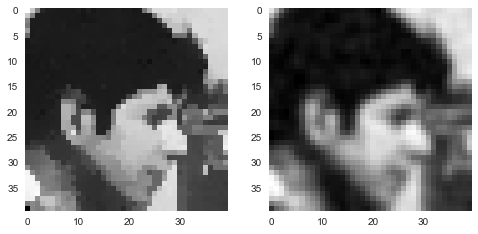

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(graph_filtered_image, cmap='gray')
ax[1].imshow(traditional_filtered_image, cmap='gray')
ax[0].grid('off')
ax[1].grid('off')